# Upgrade Notice (2025)
This notebook has been updated for compatibility with modern Python, ML, and plotting libraries.

# DEEPLY PEEVED: Neural Nets for Volcano Prediction


In [3]:
import numpy as np
from util import load_hypocenters, PuuOo, load_puuoo_eqs, GetTimeToEruption, GetTimeSinceEruption, GetEQRates
from matplotlib import pyplot as plt
import datetime
from sklearn import ensemble as ml_models
from sklearn import metrics
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim

%matplotlib inline

## Prepare dataset/dataloader

In [21]:
from __future__ import absolute_import, print_function

import os
import os.path as osp
from glob import glob

import numpy as np
import random
import scipy.io as sio
import torch
from torch.utils import data
from sklearn.preprocessing import StandardScaler
from util import load_hypocenters, PuuOo, load_puuoo_eqs


class BaseEarthquakes(data.Dataset):
    """Earthquake and Eruption Dataset"""

    def __init__(self, root, eruption_csv_path, eq_csv_path, split):
        self.root  = root
        self.split = split
        self.eruption_csv_path = eruption_csv_path
        self.eq_csv_path = eq_csv_path
        self._get_east_rift_zone()
        self._load_data()

        self._normalize()
        
    def _get_east_rift_zone(self): 
        self.p = PuuOo(self.eruption_csv_path)
        time, lat, lon, depth, mag = load_puuoo_eqs(self.eq_csv_path)
        
        latpts = np.array([19.3,19.5])
        lonpts = np.array([-155.5,-155])
        A      = np.array([lonpts,[1,1]]).T
        line   = np.linalg.solve(A, latpts)   
        croplocs = lat - line[0]*lon - line[1]        
        idx = [j for j in range(len(lon)) if croplocs[j]<=0]
        
        self.time = np.array(time)[idx]
        self.lat = np.array(lat)[idx]
        self.lon = np.array(lon)[idx]
        self.depth = np.array(depth)[idx]
        self.mag = np.array(mag)[idx]
        
        print(len(idx))
    
    def _normalize(self):
        scaler = StandardScaler()
        scaler.fit(self.x)
        self.x = scaler.transform(self.x)
    
    def _load_data(self):
        # Create data list via train, val split

        if self.split in ["train", "val", "test"]:
            random.seed(0)
            percent_train = 0.7 
            percent_dev   = 0.2 # Percent test is what is left
            
            # Make additional array for erupting or not
            erupt = np.array([self.p.was_erupting(t) for t in self.time])
            
            # Get indices of eruption and non-eruption earthquakes so we can split both
            eruption_idx    = [i for i, e in enumerate(erupt) if e == True]
            no_eruption_idx = [i for i, e in enumerate(erupt) if e == False]

            num_train_eruptions = int(percent_train * len(eruption_idx))
            num_val_eruptions   = int(percent_dev * len(eruption_idx))
            num_test_eruptions  = len(eruption_idx) - num_val_eruptions - num_train_eruptions

            num_train_no_eruptions = int(percent_train * len(no_eruption_idx))
            num_val_no_eruptions   = int(percent_dev * len(no_eruption_idx))
            num_test_no_eruptions  = len(no_eruption_idx) - num_val_no_eruptions - num_train_no_eruptions
            
            train_idx = sorted(random.sample(eruption_idx, num_train_eruptions))
            remaining = sorted(list(set(eruption_idx) - set(train_idx)))
            val_idx   = sorted(random.sample(remaining, num_val_eruptions))
            test_idx  = sorted(list(set(remaining) - set(val_idx)))
            
            train_idx += sorted(random.sample(no_eruption_idx, num_train_no_eruptions))
            remaining  = sorted(list(set(no_eruption_idx) - set(train_idx)))
            val_idx   += sorted(random.sample(remaining, num_val_no_eruptions))
            test_idx  += sorted(list(set(remaining) - set(val_idx)))
            
            print(len(train_idx))
            print(len(val_idx))
            print(len(test_idx))
            print(len(train_idx) + len(val_idx) + len(test_idx))
            print(len(erupt))
            
            assert(len(train_idx) + len(val_idx) + len(test_idx) == len(erupt))
            
            if self.split == "train":
                idx = train_idx
            elif self.split == "val":
                idx = val_idx
            elif self.split == "test":
                idx = test_idx
            
            # Shuffle for data loader
            
            random.shuffle(idx)
            self.idx = idx
            
            self.time = self.time[idx]
            self.lat = self.lat[idx]
            self.lon = self.lon[idx]
            self.depth = self.depth[idx]
            self.mag = self.mag[idx]
            self.erupt = erupt[idx]
            
            self.y = self.erupt
            self.x = np.array([self.lat, self.lon, \
                               self.depth, self.mag]).T
            
        else:
            raise ValueError("Invalid split name: {}".format(self.split))

    def _get_label_weights(self):
        # Get weights for a given dataset
        num_erupt = np.sum(self.y)
        total = len(self.y)
        weights = [1, total/num_erupt]

        return weights
    
    def __getitem__(self, index):
        raise NotImplementedError
        
    def __len__(self):
        return len(self.erupt)

class NoDerivedFeatures(BaseEarthquakes):
    
    def __init__(self, **kwargs):
        super(NoDerivedFeatures, self).__init__(**kwargs)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
class ExtraFeatures(BaseEarthquakes):
    
    def __init__(self, **kwargs):
        super(ExtraFeatures, self).__init__(**kwargs)
        self.derive_extra_features()
        self._normalize()
    
    def derive_extra_features(self):
        self.SecsToEruption = GetTimeToEruption(self.time, self.p)
        self.SecsSinceEruption = GetTimeSinceEruption(self.time, self.p)
        self.EQsLastDay, self.EQsLastWeek, self.EQsLastMonth = GetEQRates(self.time)
        self.x = np.hstack((self.x, self.EQsLastMonth[:,np.newaxis]))
        
    def __getitem__(self, index):
        return self.x[index], int(self.y[index])


    

In [22]:
eruption_csv_path = 'PuuOo.csv'
eq_csv_path       = 'puuoo_earthquakes.csv' 

dataset_train = ExtraFeatures(
        root=".",
        eruption_csv_path=eruption_csv_path, 
        eq_csv_path=eq_csv_path,    
        split="train",
    )

dataset_val = ExtraFeatures(
        root=".",
        eruption_csv_path=eruption_csv_path, 
        eq_csv_path=eq_csv_path,    
        split="val",
    )

dataset_test = ExtraFeatures(
        root=".",
        eruption_csv_path=eruption_csv_path, 
        eq_csv_path=eq_csv_path,    
        split="test",
    )


loader_train = DataLoader(dataset_train, batch_size=50)
loader_val = DataLoader(dataset_val, batch_size=50)
loader_test = DataLoader(dataset_test, batch_size=50)


3764
2633
752
379
3764
3764
3764
2633
752
379
3764
3764
3764
2633
752
379
3764
3764
3764
2633
752
379
3764
3764
3764
2633
752
379
3764
3764


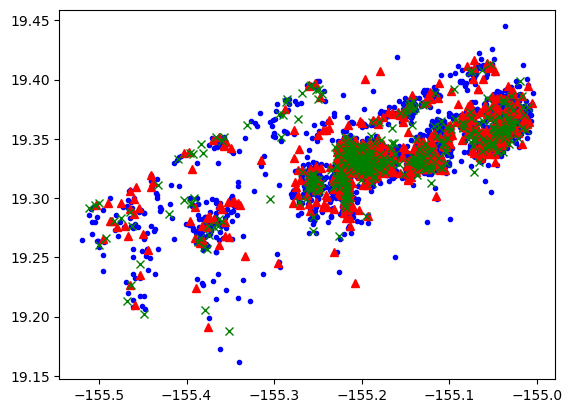

In [23]:
plt.figure()
plt.plot(dataset_train.lon, dataset_train.lat, 'b.', label='training')
plt.plot(dataset_val.lon, dataset_val.lat, 'r^', label='dev')
plt.plot(dataset_test.lon, dataset_test.lat, 'gx', label='test')

In [24]:
np.array(dataset_train.idx)

array([2352, 1174, 1468, ..., 3445,    0, 3219], shape=(2633,))

In [25]:
np.savetxt('train.txt', sorted(dataset_train.idx), '%d')
np.savetxt('dev.txt', sorted(dataset_val.idx), '%d')
np.savetxt('test.txt', sorted(dataset_test.idx), '%d')


## Build Model

In [26]:
def get_two_layer_model(input_features, hidden_layer_sizes=[1000,500], output_size=1):

    model = nn.Sequential(
        nn.Linear(input_features, hidden_layer_sizes[0]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[0], hidden_layer_sizes[1]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[1],output_size)
    )
    
    return model.double()

def get_four_layer_model(input_features, hidden_layer_sizes=[1000,1000,1000,1000], output_size=1):

    model = nn.Sequential(
        nn.Linear(input_features, hidden_layer_sizes[0]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[0], hidden_layer_sizes[1]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[1], hidden_layer_sizes[2]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[2], hidden_layer_sizes[3]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[3],output_size),
    )
    
    return model.double()


In [27]:
model = get_four_layer_model(4)
print(model.modules)

<bound method Module.modules of Sequential(
  (0): Linear(in_features=4, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=1000, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1000, out_features=1000, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1000, out_features=1000, bias=True)
  (7): ReLU()
  (8): Linear(in_features=1000, out_features=1, bias=True)
)>


## Train!

In [28]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    num_pos     = 0
    predicted   = []
    val_label   = []
    
    with torch.no_grad():
        
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = torch.nn.functional.sigmoid(model(x))
            
            preds = torch.squeeze((scores > 0.5).long())

            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            num_pos += (preds).sum()
            
            predicted += preds.tolist()
            val_label += y.tolist()
            
        acc = float(num_correct) / num_samples
        print('Accuracy on ' + loader.dataset.split + ': Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print(metrics.confusion_matrix(val_label, predicted))
        print('Kappa:', metrics.cohen_kappa_score(val_label, predicted))
        print('AUROC:', metrics.roc_auc_score(val_label, predicted))
        print('Num pos: %d' % num_pos)
        
def train_model(model, optimizer, epochs=1):
    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    
    weights = loader_train.dataset._get_label_weights()
    weights = torch.tensor(weights)
    print('Weghts are: ', weights)
    #criterion = nn.CrossEntropyLoss(weight=weights.double())
    #criterion = nn.BCEWithLogitsLoss(pos_weight=weights[1])
    criterion = nn.BCEWithLogitsLoss()
    criterion.to(device)

    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            
            y = torch.unsqueeze(y,1)
           
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
                    
            scores = model(x)
            loss = criterion(scores.float(), y.float())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

        if e % print_every == 0:
            print('Epoch %d, loss = %.4f' % (e, loss.item()))
            check_accuracy(loader_train, model)
            check_accuracy(loader_val, model)
            check_accuracy(loader_test, model)
            print()

In [29]:
learning_rate = 0.05
weight_decay  = 0.001
print_every = 150

device = torch.device('cpu')
dtype = torch.float64

two_layer_model = get_two_layer_model(5)
optimizer = optim.SGD(two_layer_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_model(two_layer_model, optimizer, epochs=1000)

Weghts are:  tensor([1.0000, 4.4627], dtype=torch.float64)
Epoch 0, loss = 0.5650
Accuracy on train: Got 2148 / 2633 correct (81.58)
[[2032   11]
 [ 474  116]]
Kappa: 0.26524495670600867
AUROC: 0.5956129653135551
Num pos: 127
Accuracy on val: Got 601 / 752 correct (79.92)
[[579   5]
 [146  22]]
Kappa: 0.17457548267038836
AUROC: 0.5611953685583823
Num pos: 27
Accuracy on test: Got 305 / 379 correct (80.47)
[[293   0]
 [ 74  12]]
Kappa: 0.20046752950567315
AUROC: 0.5697674418604651
Num pos: 12

Epoch 0, loss = 0.5650
Accuracy on train: Got 2148 / 2633 correct (81.58)
[[2032   11]
 [ 474  116]]
Kappa: 0.26524495670600867
AUROC: 0.5956129653135551
Num pos: 127
Accuracy on val: Got 601 / 752 correct (79.92)
[[579   5]
 [146  22]]
Kappa: 0.17457548267038836
AUROC: 0.5611953685583823
Num pos: 27
Accuracy on test: Got 305 / 379 correct (80.47)
[[293   0]
 [ 74  12]]
Kappa: 0.20046752950567315
AUROC: 0.5697674418604651
Num pos: 12

Epoch 150, loss = 0.5360
Accuracy on train: Got 2222 / 2633 cor

In [30]:
print(np.sum(1-loader_train.dataset.y)/len(loader_train.dataset.y))
print(np.sum(1-loader_val.dataset.y)/len(loader_val.dataset.y))


0.7759210026585643
0.776595744680851


In [33]:
learning_rate = 0.02
weight_decay  = 0.01
print_every = 50

device = torch.device('cpu')
dtype = torch.float64

four_layer_model = get_four_layer_model(5)
optimizer = optim.SGD(four_layer_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_model(four_layer_model, optimizer, epochs=1000)

Weghts are:  tensor([1.0000, 4.4627], dtype=torch.float64)
Epoch 0, loss = 0.5853
Epoch 0, loss = 0.5853
Accuracy on train: Got 2043 / 2633 correct (77.59)
[[2043    0]
 [ 590    0]]
Kappa: 0.0
AUROC: 0.5
Num pos: 0
Accuracy on val: Got 584 / 752 correct (77.66)
[[584   0]
 [168   0]]
Kappa: 0.0
AUROC: 0.5
Num pos: 0
Accuracy on test: Got 293 / 379 correct (77.31)
[[293   0]
 [ 86   0]]
Kappa: 0.0
AUROC: 0.5
Num pos: 0

Accuracy on train: Got 2043 / 2633 correct (77.59)
[[2043    0]
 [ 590    0]]
Kappa: 0.0
AUROC: 0.5
Num pos: 0
Accuracy on val: Got 584 / 752 correct (77.66)
[[584   0]
 [168   0]]
Kappa: 0.0
AUROC: 0.5
Num pos: 0
Accuracy on test: Got 293 / 379 correct (77.31)
[[293   0]
 [ 86   0]]
Kappa: 0.0
AUROC: 0.5
Num pos: 0

Epoch 50, loss = 0.5577
Epoch 50, loss = 0.5577
Accuracy on train: Got 2173 / 2633 correct (82.53)
[[2024   19]
 [ 441  149]]
Kappa: 0.3262141085707736
AUROC: 0.621621161966865
Num pos: 168
Accuracy on val: Got 608 / 752 correct (80.85)
[[576   8]
 [136  32

## Now for regression problem

In [34]:
class TimeDS(BaseEarthquakes):
    
    def __init__(self, **kwargs):
        super(TimeDS, self).__init__(**kwargs)
        self.derive_extra_features()
        self._normalize()
    
    def derive_extra_features(self):
        self.SecsToEruption = GetTimeToEruption(self.time, self.p)
        self.SecsSinceEruption = GetTimeSinceEruption(self.time, self.p)
        self.EQsLastDay, self.EQsLastWeek, self.EQsLastMonth = GetEQRates(self.time)
        self.x = np.hstack((self.x, self.EQsLastMonth[:,np.newaxis]))
        self.y = self.SecsToEruption.reshape((-1,1))
        scaler = StandardScaler()
        scaler.fit(self.y)
        self.y = scaler.transform(self.y)
        
    def __getitem__(self, index):
     
        return self.x[index], self.y[index]



In [35]:
eruption_csv_path = 'PuuOo.csv'
eq_csv_path       = 'puuoo_earthquakes.csv' 

dataset_train = TimeDS(
        root=".",
        eruption_csv_path=eruption_csv_path, 
        eq_csv_path=eq_csv_path,    
        split="train",
    )

dataset_val = TimeDS(
        root=".",
        eruption_csv_path=eruption_csv_path, 
        eq_csv_path=eq_csv_path,    
        split="val",
    )

dataset_test = TimeDS(
        root=".",
        eruption_csv_path=eruption_csv_path, 
        eq_csv_path=eq_csv_path,    
        split="test",
    )


loader_train = DataLoader(dataset_train, batch_size=50)
loader_val = DataLoader(dataset_val, batch_size=50)
loader_test = DataLoader(dataset_test, batch_size=50)

3764
2633
752
379
3764
3764
3764
2633
752
379
3764
3764
3764
2633
752
379
3764
3764
3764
2633
752
379
3764
3764
3764
2633
752
379
3764
3764


In [36]:
def get_two_layer_time_model(input_features, hidden_layer_sizes=[1000,500], output_size=1):

    model = nn.Sequential(
        nn.Linear(input_features, hidden_layer_sizes[0]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[0], hidden_layer_sizes[1]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[1],output_size),
    )
    
    return model.double()

def get_four_layer_time_model(input_features, hidden_layer_sizes=[1000,1000,1000,1000], output_size=1):

    model = nn.Sequential(
        nn.Linear(input_features, hidden_layer_sizes[0]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[0], hidden_layer_sizes[1]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[1], hidden_layer_sizes[2]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[2], hidden_layer_sizes[3]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[3],output_size),
    )
    
    return model.double()

In [37]:
def check_accuracy(loader, model, criterion):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    num_pos     = 0
    predicted   = []
    val_label   = []
    
    with torch.no_grad():
        
        num_total = 0
        total_loss = 0
        
        for x, y in loader:
          
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            
            num_batch = x.shape[0]
            num_total += num_batch
            
            scores = model(x)
            loss = criterion(scores.float(), y.float())
            
            total_loss += loss.item() * num_batch  
            
            
        average_loss = np.sqrt(total_loss/num_total)
        print(('RMSE on ' + loader.dataset.split + ": %.2f") % average_loss)

def train_model(model, optimizer, epochs=1):
    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    
    criterion = nn.MSELoss()
    criterion.to(device)

    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
          
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
                    
            scores = model(x)
            loss = criterion(scores.float(), y.float())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

        if e % print_every == 0:
            print('Epoch %d, loss = %.4f' % (e, loss.item()))
            check_accuracy(loader_train, model, criterion)
            check_accuracy(loader_val, model, criterion)
            check_accuracy(loader_test, model, criterion)

In [39]:
learning_rate = 0.001
weight_decay  = 0.00001
print_every = 150

device = torch.device('cpu')
dtype = torch.float64

two_layer_model = get_two_layer_time_model(5)
optimizer = optim.SGD(two_layer_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_model(two_layer_model, optimizer, epochs=10000)

Epoch 0, loss = 0.6241
RMSE on train: 0.96
RMSE on val: 0.97
RMSE on test: 0.97
Epoch 150, loss = 0.4656
RMSE on train: 0.87
Epoch 150, loss = 0.4656
RMSE on train: 0.87
RMSE on val: 0.92
RMSE on test: 0.91
RMSE on val: 0.92
RMSE on test: 0.91
Epoch 300, loss = 0.4384
RMSE on train: 0.86
RMSE on val: 0.92
RMSE on test: 0.91
Epoch 300, loss = 0.4384
RMSE on train: 0.86
RMSE on val: 0.92
RMSE on test: 0.91
Epoch 450, loss = 0.4138
RMSE on train: 0.85
RMSE on val: 0.93
RMSE on test: 0.91
Epoch 450, loss = 0.4138
RMSE on train: 0.85
RMSE on val: 0.93
RMSE on test: 0.91
Epoch 600, loss = 0.3931
RMSE on train: 0.83
RMSE on val: 0.94
RMSE on test: 0.91
Epoch 600, loss = 0.3931
RMSE on train: 0.83
RMSE on val: 0.94
RMSE on test: 0.91
Epoch 750, loss = 0.3747
RMSE on train: 0.82
RMSE on val: 0.94
RMSE on test: 0.92
Epoch 750, loss = 0.3747
RMSE on train: 0.82
RMSE on val: 0.94
RMSE on test: 0.92
Epoch 900, loss = 0.3590
RMSE on train: 0.81
RMSE on val: 0.95
RMSE on test: 0.92
Epoch 900, loss = 

In [40]:
# Make plots of pred v. actual
def get_preds(loader, model):

    predicted   = []
    val_label   = []
    
    with torch.no_grad():
   
        for x, y in loader:
          
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            
            scores = model(x)
            
            predicted += scores.tolist()
            val_label += y.tolist()
    
    return predicted, val_label
        


In [41]:
predicted, actual = get_preds(loader_test, two_layer_model)

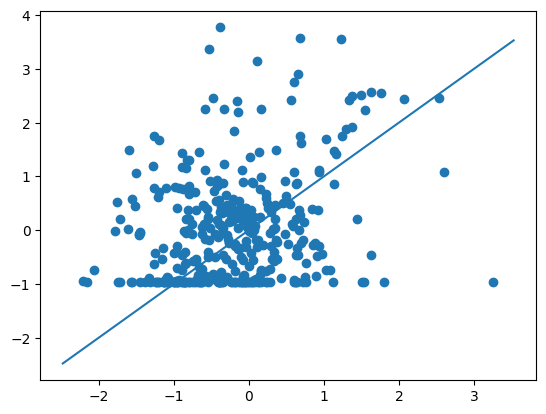

In [42]:
plt.scatter(predicted, actual)
left, right = plt.xlim()
plt.plot([left, right], [left,right])
plt.show()


In [43]:
metrics.r2_score(actual, predicted)

-0.22241684674701512